# Plasma PINN Project

In [1]:
import h5py
import torch
import numpy as np
from PIL import Image, ImageOps
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from utils.constants import *
from pinn_setup import PINN

rcParams['figure.dpi'] = 150

In [17]:
# Data storage variables
DATA_FILE_NAME = 'data/plasma_data.h5'
POTENTIAL_IMG_NAME = 'data/potential.png'
NT = 4
NX, NY = 128, 89
N_FRAME = NX * NY
PHI_MAX, PHI_MIN = 525, 50
FRAME_IDX = 1 # Only frame for which phi and Er are available

# Computing variables
ER_SMOOTH_SIGMA = 2 # Standard deviation for Gaussian blurring

# Plotting variables
SPACE_FACTOR = 100.0 * MINOR_RADIUS  # cm conversion
SCATTER_POINT_SIZE = 10

# Prepare Data

Load Training Data

In [18]:
ne_frames = []
Te_frames = []

vec_to_mat = lambda vec: np.fliplr(vec.reshape(NX,NY,order='F')).T

# Open file object with HDF5 datasets,
# each of shape (NT*N_FRAME, 1)
with h5py.File(DATA_FILE_NAME, 'r') as f:
    for frame_idx in range(NT):
        frame_idxs = range(
            frame_idx*N_FRAME,
            (frame_idx + 1)*N_FRAME
        )

        ne_frames.append(
            vec_to_mat(f['y_den'][frame_idxs]) * PLASMA_DENSITY
        )
        Te_frames.append(
            vec_to_mat(f['y_Te'][frame_idxs]) * ELECTRON_TEMP
        )
        # # Extra, uneeded
        # t = f['x_t'][frame_idxs[0]] # Time of frame (s?)
        # z = f['x_z'][frame_idxs] # z location of frame (units?)
        # Ti = f['y_Ti'][frame_idxs] * ION_TEMP
    
    # Constant grid over time
    xx = vec_to_mat(f['x_x'][frame_idxs]) * SPACE_FACTOR
    yy = vec_to_mat(f['x_y'][frame_idxs]) * SPACE_FACTOR

In [19]:
x_min = np.min(xx)
x_max = np.max(xx)
y_min = np.min(yy)
y_max = np.max(yy)

dx = np.abs(np.diff(xx, axis=1)[0,0])
dy = np.abs(np.diff(yy, axis=0)[0,0])

Compute Testing Potential and E Field

Potential is drawn from figure in paper, not avaialable in repo. plot_results.py passes density training data when plotting potential...

In [35]:
phi_img = Image.open(POTENTIAL_IMG_NAME)
phi_mat = np.asarray(ImageOps.grayscale(phi_img), dtype=np.float64)

# Down sample and scale
slices = tuple(
    np.linspace(0, phi_mat.shape[i] - 1, num=xx.shape[i], dtype=int)
    for i in range(len(xx.shape))
)
mesh = np.ix_(*slices)
phi_frame = (
    phi_mat[mesh]/(phi_mat.max() - phi_mat.min())
) * (PHI_MAX - PHI_MIN) + PHI_MIN

def get_Er(phi, dx):
    # Compute electric field in x/radial direction and denoise
    # Neglect y/poloidal direction
    Er = -np.gradient(phi, dx)[1] * 100 # V/cm to V/m
    Er = gaussian_filter(Er, sigma=ER_SMOOTH_SIGMA)
    return Er

Er_frame = get_Er(phi_frame, dx)

Visualize Data

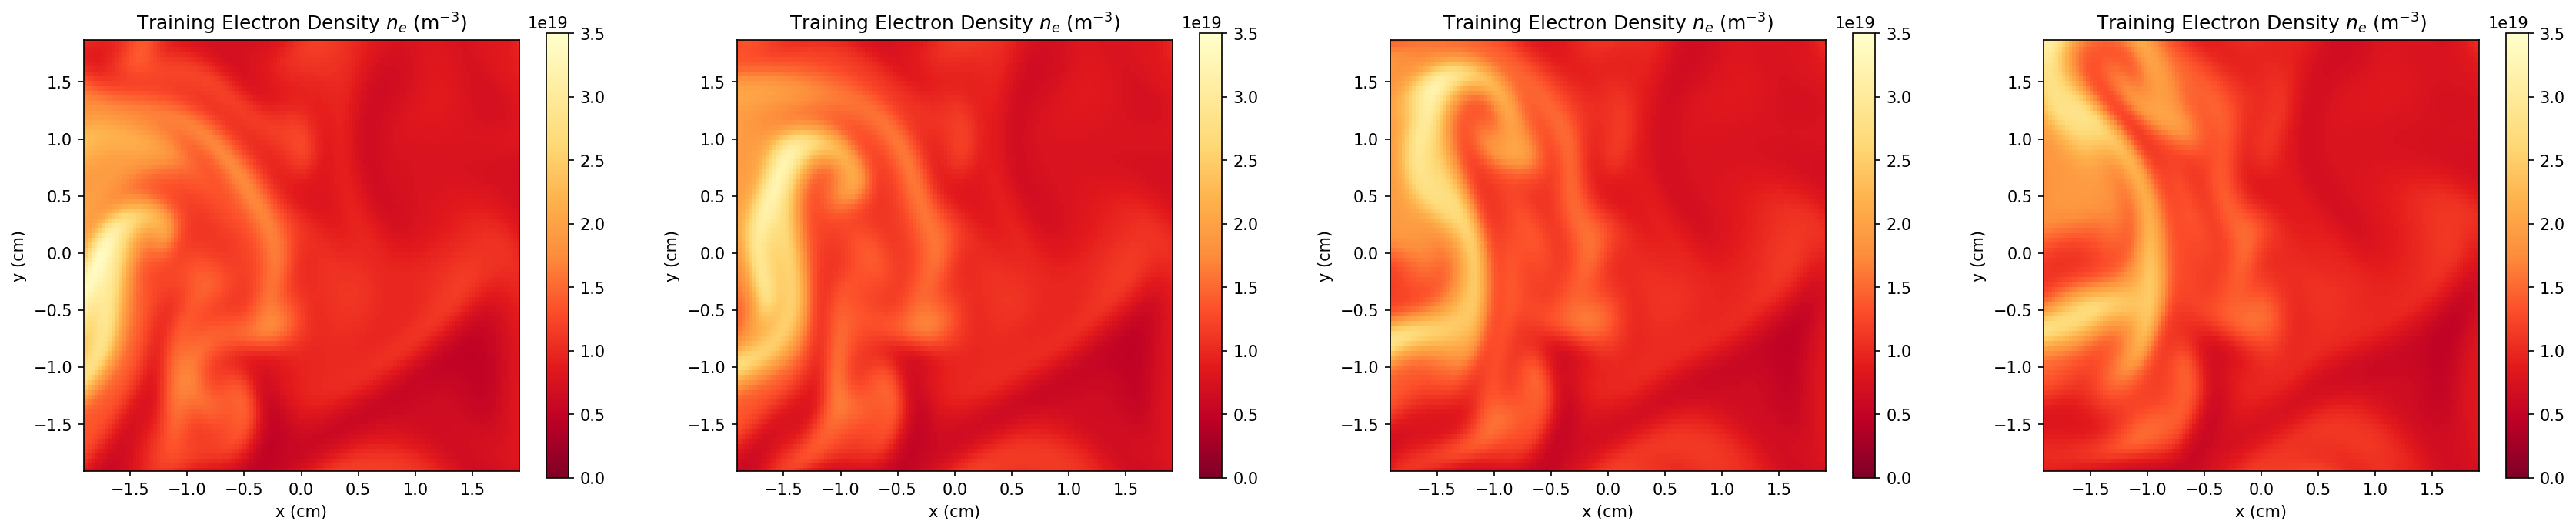

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=NT, figsize=(7*NT,5))

for i in range(NT):
    im = ax[i].pcolor(
        xx, yy, ne_frames[i],
        vmin=0, vmax=3.5e19, cmap='YlOrRd_r'
    )
    cb = plt.colorbar(im)

    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')
    ax[i].set_title('Training Electron Density $n_e$ (m$^{-3}$)')
    
    ax[i].set_aspect('equal')

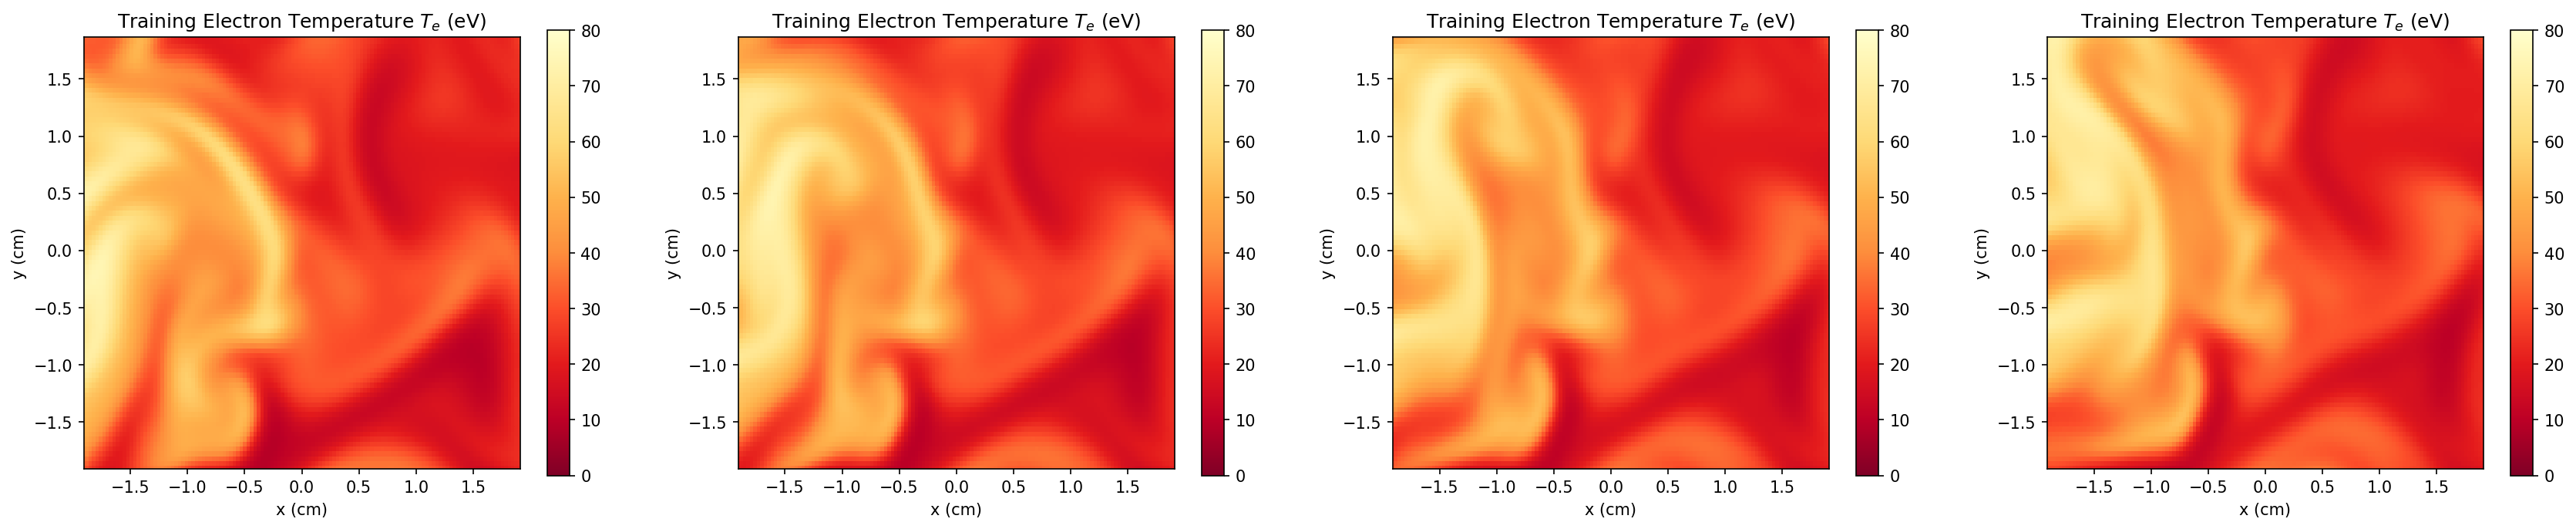

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=NT, figsize=(7*NT,5))

for i in range(NT):
    im = ax[i].pcolor(
        xx, yy, Te_frames[i],
        vmin=0, vmax=80,
        cmap='YlOrRd_r'
    )
    cb = plt.colorbar(im)
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')
    ax[i].set_title('Training Electron Temperature $T_e$ (eV)')
    
    ax[i].set_aspect('equal')

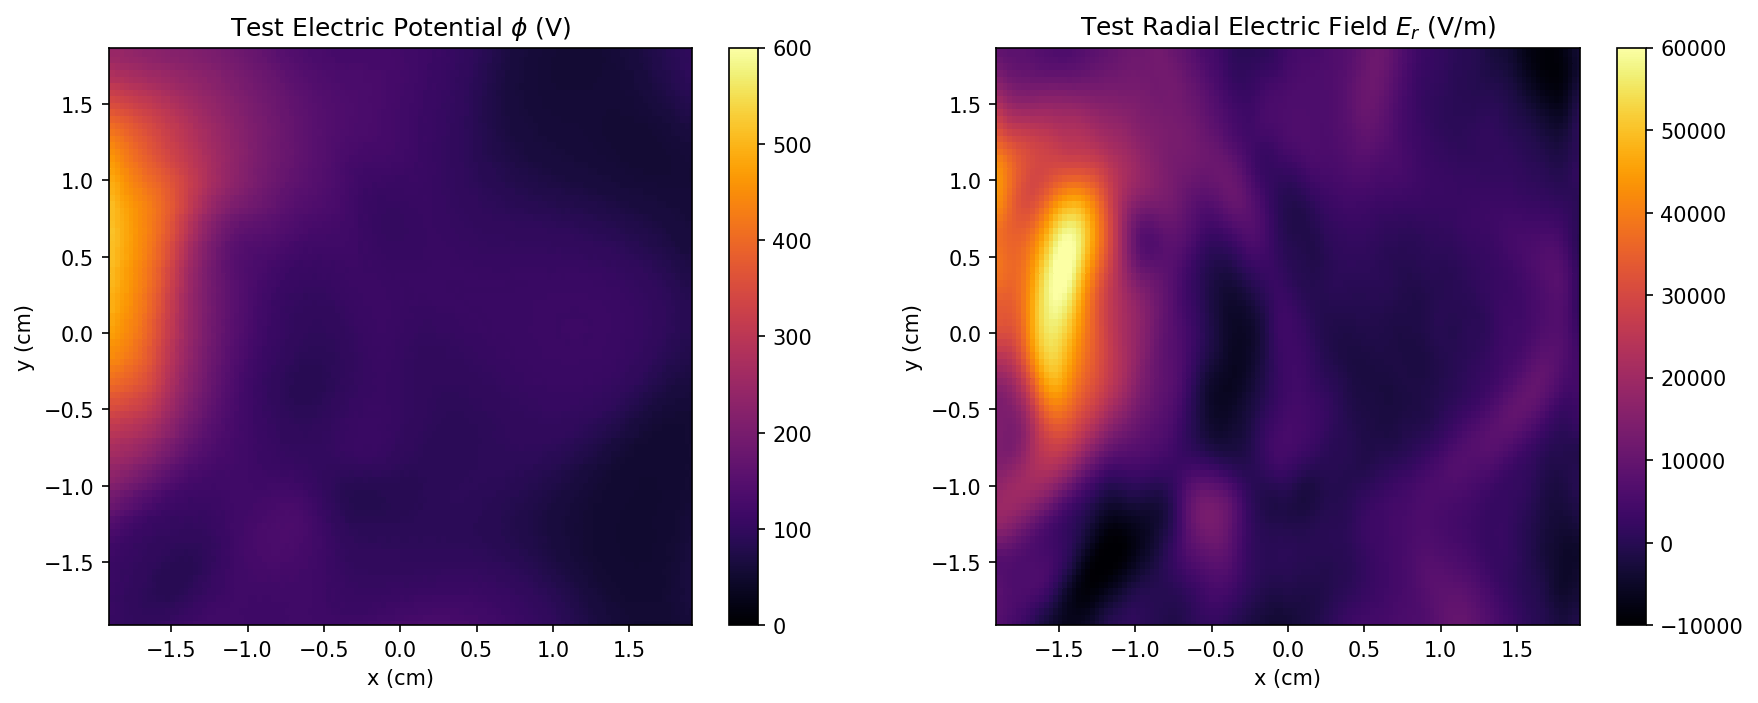

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7*2,5))

i = 0
im = ax[i].pcolor(
    xx, yy, phi_frame,
    vmin=0, vmax=600,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Electric Potential $\phi$ (V)')

i = 1
im = ax[i].pcolor(
    xx, yy, Er_frame,
    vmin=-10_000, vmax=60_000,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Radial Electric Field $E_r$ (V/m)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect('equal')

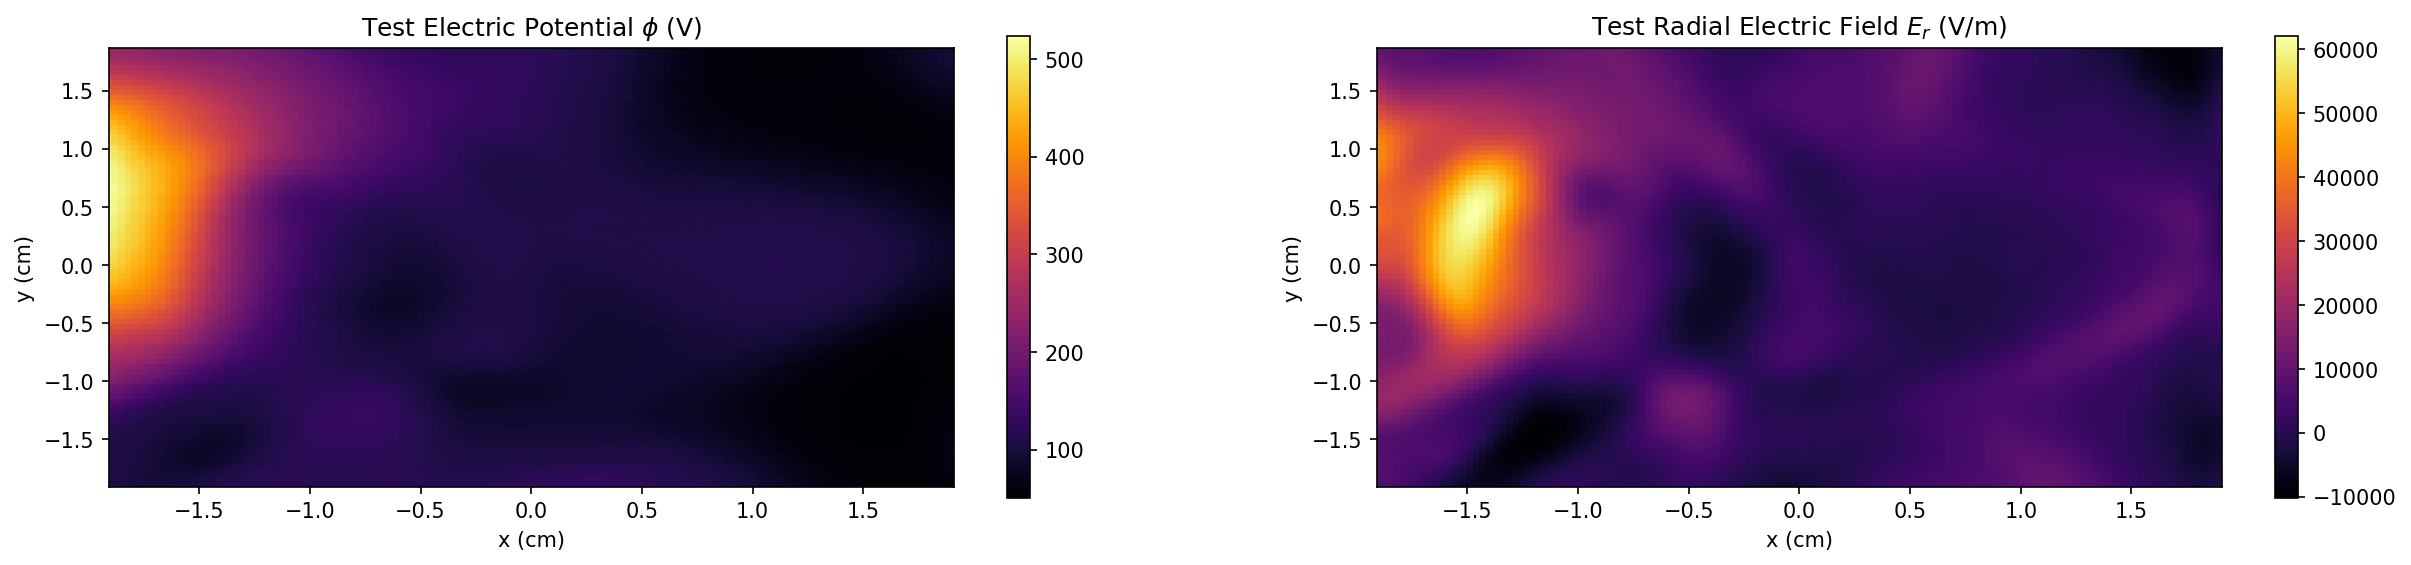

In [24]:
# Squashed plot to eyeball verify against paper plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10*2,4))

i = 0
im = ax[i].pcolor(
    xx, yy, phi_frame,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Electric Potential $\phi$ (V)')

i = 1
im = ax[i].pcolor(
    xx, yy, Er_frame,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Radial Electric Field $E_r$ (V/m)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect(0.75*dx/dy)

# Train PINN

Issues
- PDE residuals are computed with log ne and log Te, so ne/Te must be positive
    - PINN now predicts log ne, Te values and evaluates losses on log values, as reccomended by GPT
    - Not fixed by ReLU over Tanh since activation not applied after last layer
- TODO! Density yields biggest losses when use_pde=True
    - Ask GPT how to fix or just train more and more?

In [25]:
def train_pinn(model, use_pde, epochs, output_rate):
    # Initalize network
    model.setup_optimizers()
    model.apply(model.xavier_init)

    # Define loss
    loss_fn = torch.nn.MSELoss()

    # Train
    if use_pde:
        print(
            'Epoch\t| ne Data Loss\t| ne PDE Loss\t| '
            'Te Data Loss\t| Te PDE Loss\t| '
            'Total Train Loss'
        )
    else:
        print(
            'Epoch\t| ne Train Loss\t| Te Train Loss\t| '
            'Total Train Loss'
        )
    
    for epoch in range(epochs):
        if use_pde:
            loss = model.train_step(
                loss_fn, model.optimizer_ne, model.optimizer_Te,
                model.optimizer_f
            )
        else:
            loss = model.train_step(
                loss_fn, model.optimizer_ne, model.optimizer_Te
            )
        
        if epoch % output_rate == 0 and use_pde:
            print(
                f'{epoch:3d}\t| {loss["ne"]:.2e}\t| '
                f'{loss["ne_pde"]:.2e}\t| {loss["Te"]:.2e}\t| '
                f'{loss["Te_pde"]:.2e}\t| {loss["total"]:.2e}'
            )
        elif epoch % output_rate == 0:
            print(
                f'{epoch:3d}\t| {loss["ne"]:.2e}\t\t| '
                f'{loss["Te"]:.2e}\t\t| {loss["total"]:.2e}'
            )

In [ ]:
use_pde = False

train_data_size = xx.size
x = xx.reshape((train_data_size, 1))
y = yy.reshape((train_data_size, 1))
t = np.zeros((train_data_size, 1))
ne = ne_frames[FRAME_IDX].reshape((train_data_size, 1))
Te = Te_frames[FRAME_IDX].reshape((train_data_size, 1))

# Define network
layers = [3, 64, 64, 64, 1]
model = PINN(x, y, t, ne, Te, layers, use_pde)

# Train ------

# Good results for use_pde = False
epochs = 50_000
output_rate = 5_000

# Mid results for use_pde = False
# epochs = 10_000
# output_rate = 1_000

# # Short training for testing
# epochs = 1000
# output_rate = 100

train_pinn(model, use_pde, epochs, output_rate)

Epoch	| ne Train Loss	| Te Train Loss	| Total Train Loss
  0	| 1.92e+03		| 1.21e+01		| 1.93e+03
5000	| 1.11e-01		| 3.30e-02		| 1.44e-01
10000	| 2.71e-02		| 1.04e-02		| 3.75e-02
15000	| 1.63e-02		| 5.71e-03		| 2.20e-02
20000	| 7.91e-03		| 3.12e-03		| 1.10e-02
25000	| 5.50e-03		| 1.97e-03		| 7.47e-03
30000	| 3.85e-03		| 2.22e-03		| 6.07e-03
35000	| 1.42e-03		| 6.91e-04		| 2.11e-03
40000	| 1.33e-03		| 6.53e-04		| 1.99e-03
45000	| 1.16e-03		| 6.82e-04		| 1.84e-03


# Evaluate PINN

In [38]:
# Make predictions
preds = model.predict(x, y, t)
ne_pred = preds['ne'].reshape((NY, NX))
Te_pred = preds['Te'].reshape((NY, NX))
if use_pde:
    phi_pred = preds['phi'].reshape((NY, NX))

Visualize Predictions

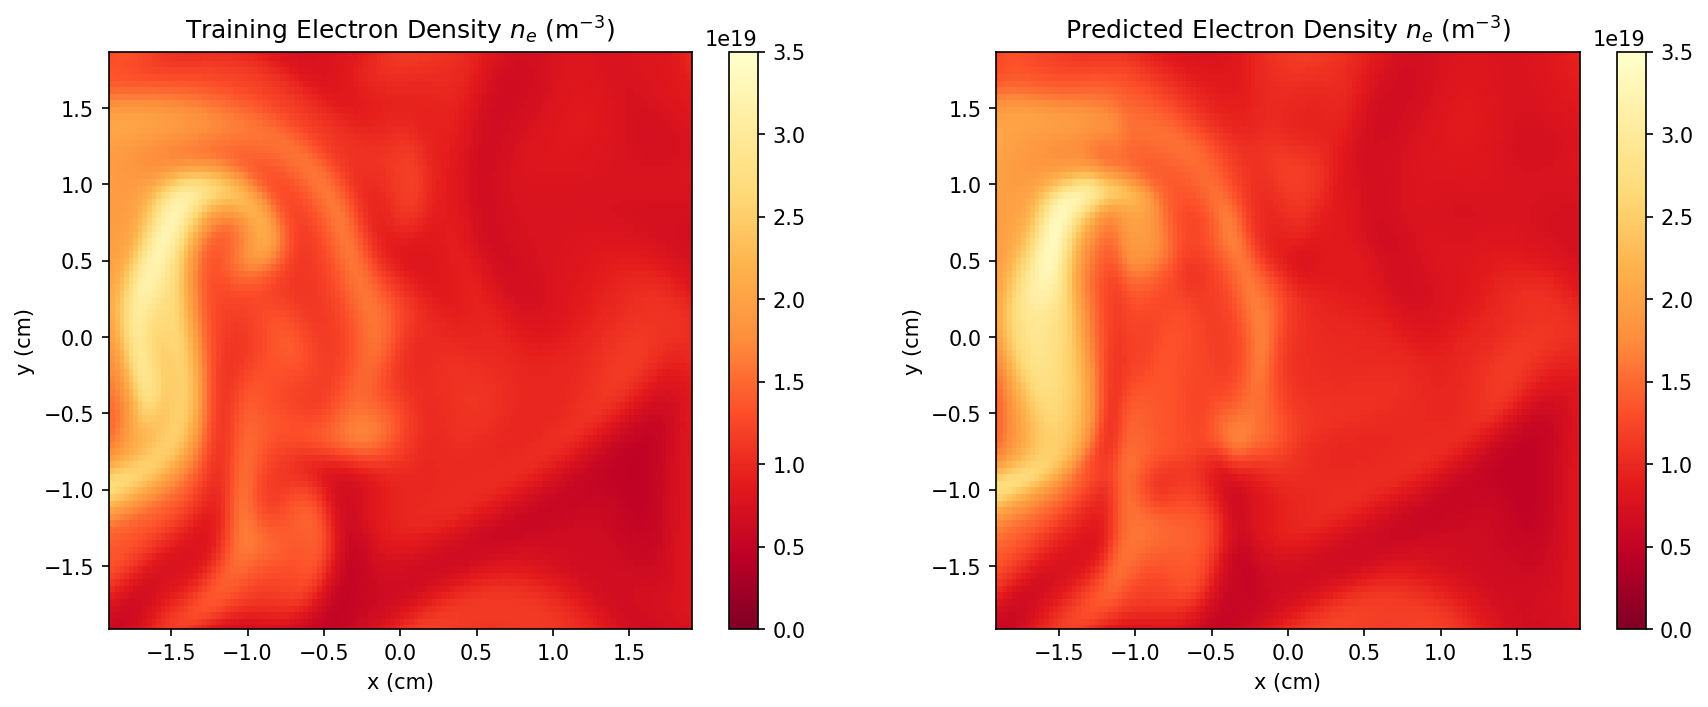

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7*2,5))

i = 0
im = ax[i].pcolor(
    xx, yy, ne_frames[FRAME_IDX],
    vmin=0, vmax=3.5e19, cmap='YlOrRd_r'
)
cb = plt.colorbar(im)
ax[i].set_title('Training Electron Density $n_e$ (m$^{-3}$)')

i = 1
im = ax[i].pcolor(
    xx, yy, ne_pred,
    vmin=0, vmax=3.5e19, cmap='YlOrRd_r'
)
cb = plt.colorbar(im)
ax[i].set_title('Predicted Electron Density $n_e$ (m$^{-3}$)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect('equal')

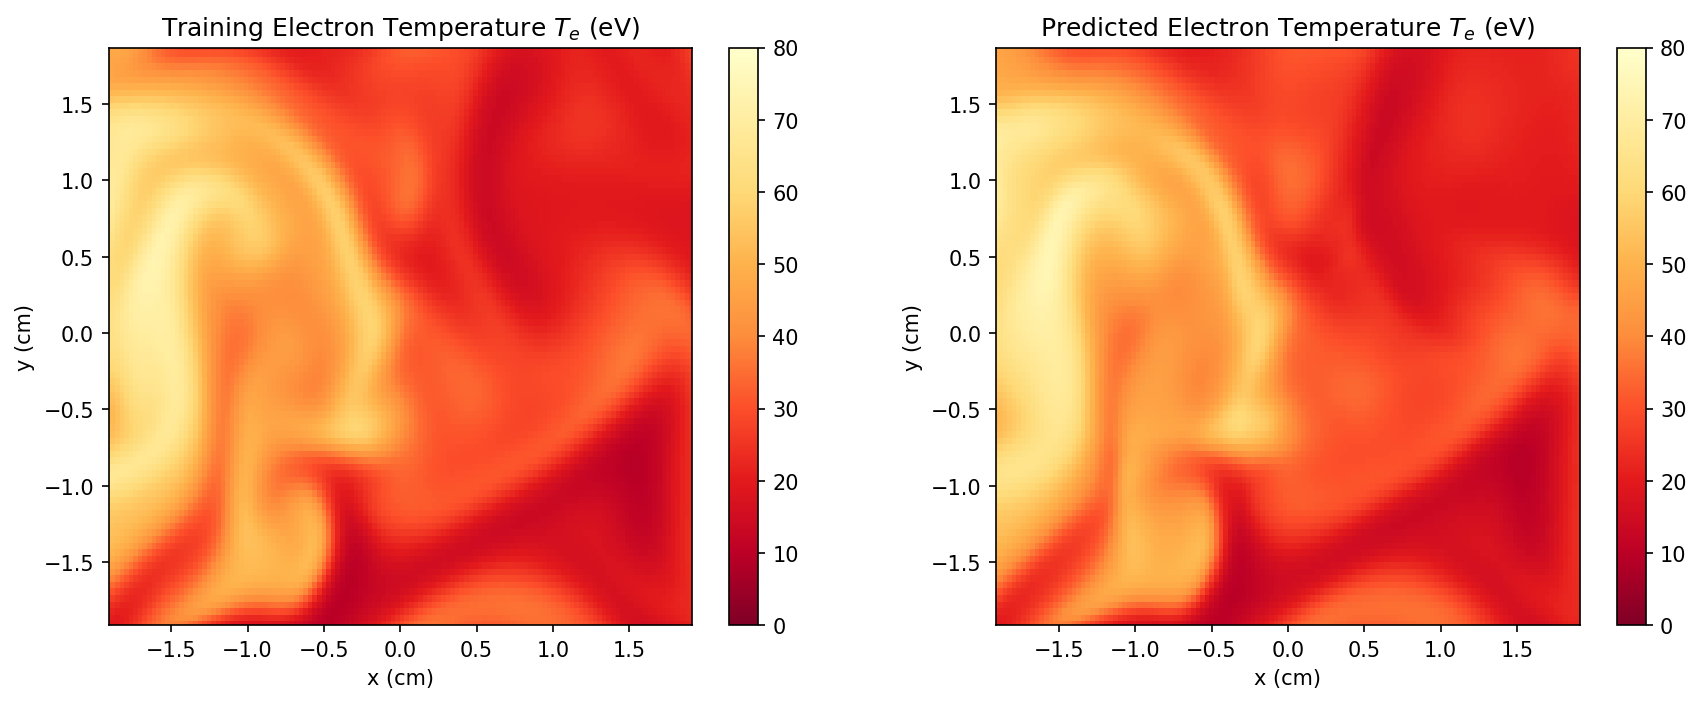

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7*2,5))

i = 0
im = ax[i].pcolor(
    xx, yy, Te_frames[FRAME_IDX],
    vmin=0, vmax=80, cmap='YlOrRd_r'
)
cb = plt.colorbar(im)
ax[i].set_title('Training Electron Temperature $T_e$ (eV)')

i = 1
im = ax[i].pcolor(
    xx, yy, Te_pred,
    vmin=0, vmax=80, cmap='YlOrRd_r'
)
cb = plt.colorbar(im)
ax[i].set_title('Predicted Electron Temperature $T_e$ (eV)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect('equal')

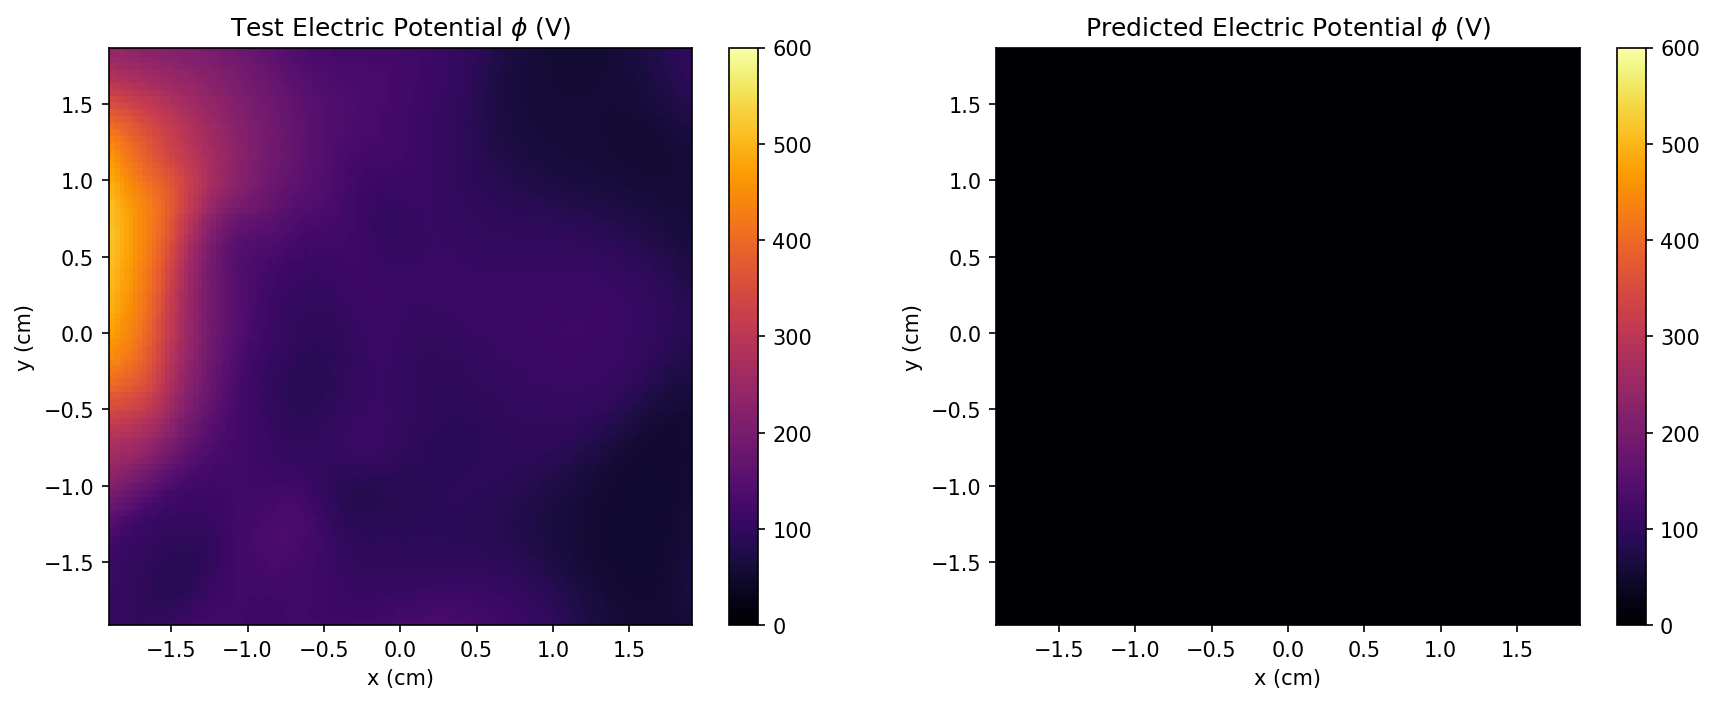

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7*2,5))

i = 0
im = ax[i].pcolor(
    xx, yy, phi_frame,
    vmin=0, vmax=600,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Electric Potential $\phi$ (V)')

i = 1
im = ax[i].pcolor(
    xx, yy, phi_pred,
    vmin=0, vmax=600,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Predicted Electric Potential $\phi$ (V)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect('equal')

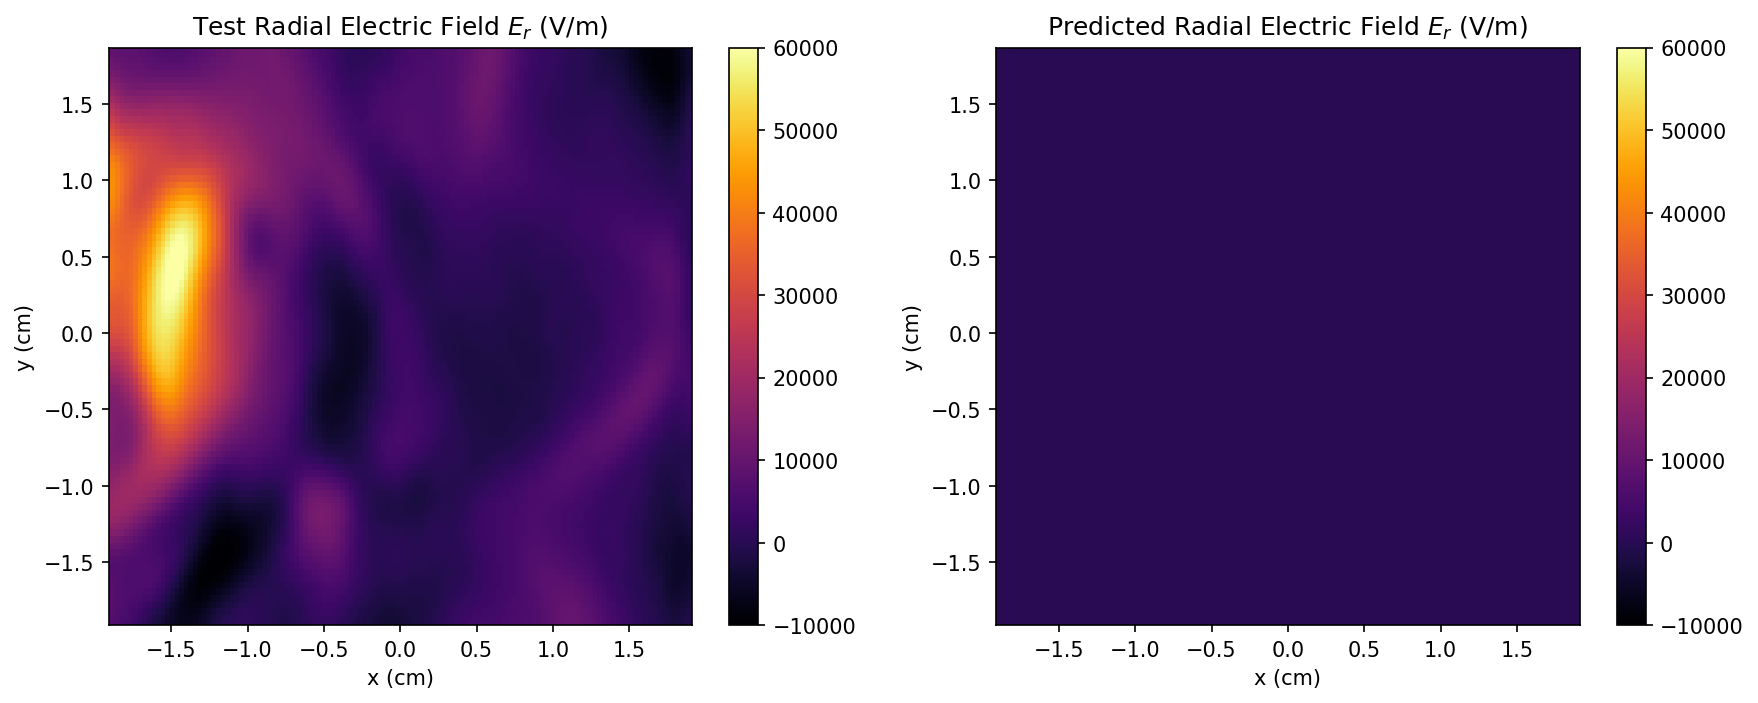

In [36]:
Er_pred = get_Er(phi_pred, dx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7*2,5))

i = 0
im = ax[i].pcolor(
    xx, yy, Er_frame,
    vmin=-10_000, vmax=60_000,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Test Radial Electric Field $E_r$ (V/m)')

i = 1
im = ax[i].pcolor(
    xx, yy, Er_pred,
    vmin=-10_000, vmax=60_000,
    cmap='inferno'
)
cb = plt.colorbar(im)
ax[i].set_title('Predicted Radial Electric Field $E_r$ (V/m)')

for i in range(2):
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')

    ax[i].set_aspect('equal')